In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.cloud import bigquery

## BQ client setup

In [4]:
def estimate_bigquery_query_cost(bq_client, query):
    
    job_config = bigquery.QueryJobConfig()
    job_config.dry_run = True
    job_config.use_query_cache = False
    query_job = bq_client.query(

        (
           query
        ),
        job_config=job_config,
    )
    
    cost_euros = (query_job.total_bytes_processed / 1024 ** 4) * 6

    print(f"{query_job.total_bytes_processed} bytes will be processed , cost ~{cost_euros}$")

In [6]:
bigquery_client= bigquery.Client(project="ingka-chscesda-solar-dev") # ingka-energy-solar-dev # ingka-energy-analytics-dev

## Varaibles for query

In [7]:
date_min = "2022-07-16"

markets = tuple(['se', 'us',''])


# Get SQL string filter condition
product_string_queries = [
    'solar', 'sol', 'sun',
    'sunpower', 'svea', 
    'solstrale', 'SOLSTRÅLE', 
    'solpaneler', 'energy', 'electricity', 
]
string_exp = ' OR '.join([f'"{exp.lower()}" in UNNEST(internal_search_terms)' for exp in product_string_queries])
print(string_exp,'\n')

"solar" in UNNEST(internal_search_terms) OR "sol" in UNNEST(internal_search_terms) OR "sun" in UNNEST(internal_search_terms) OR "sunpower" in UNNEST(internal_search_terms) OR "svea" in UNNEST(internal_search_terms) OR "solstrale" in UNNEST(internal_search_terms) OR "solstråle" in UNNEST(internal_search_terms) OR "solpaneler" in UNNEST(internal_search_terms) OR "energy" in UNNEST(internal_search_terms) OR "electricity" in UNNEST(internal_search_terms) 



## Data mapping

#### Events, searches and pages 
(`ingka-web-analytics-prod.web_data_v2.hits_events_and_pages`): 
    - Landing on clean-energy (solar) tables, and session data
    - Searched string queries in the internal search bar
#### session data 
(`ingka-web-analytics-prod.web_data_v2.sessions`) - session data. Contains `icm_id`, `session_id` and `visitor_id`.

#### Customer data
- (`ikea-icm-prod.customer_master_golden_record_masked.v_cm_customer`) - Contains data on customer. *** waiting for access approval 
for info and access permissions *** 
- Alternatively - Use SCV **[single customer view](https://datacatalog.ingka.com/data/34/)** data for purchase history. Join `icm_id` key with hits events and pages. Start with [US data tables](https://datacatalog.ingka.com/schema/160/) until the Sweden data becomes available early August 2022.

Info on how to join session data to SCV (Jane Robinson):
```
Clickstream data is joined to our wider SCV dataset based on transaction ID or Sales Order Number (sono). 
We can then use the vistor ID assigned to these transactions to gather full browsing (and purchasing) history of this customer. 
If a customer has not purchased, we can use their ICM ID (when they are logged in) to gather full browsing history for that customer, 
conditional that the customer has made a transaction in store and they have an ICM ID. Currently, no clickstream data 
is surfaced in SCV KPI dashboards but is available to be used in the datasets
```

##### TODO:
- **Map google organic searches** (`ingka-do-seo-prod.integrated_search.gsc_est_revenue`) to IKEA user session activity. Attribution of organic searches, or grouping by user/session, is currently not possible
- Find **transactions data**, to see what visitors who reached CES goal have also bought (Use SCV?).



## Landings data

In [74]:
# Visited pages
query_string = """
SELECT 
    date_hit
    , visitor_id
    , session_id
    -- , page_urls
FROM (
    SELECT 
    date_hit
    , visitor_id
    , session_id
    , page_urls
    , EXISTS(SELECT * FROM UNNEST(page_urls) AS x WHERE REGEXP_CONTAINS(x, ".+?clean-energy.+")) as exist
    FROM (
        SELECT 
            date_hit
            , visitor_id
            , session_id
            , ARRAY_AGG(DISTINCT page_url) as page_urls
        FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
        WHERE 
            date_hit = '2022-07-01' 
            -- AND website_market_short in ('se')
            AND event_category like '%page%'
            AND page_url is not NULL
        GROUP BY
            date_hit
            , visitor_id
            , session_id
        -- ORDER BY visitor_id
    ) pages
)
WHERE exist is TRUE

"""

estimate_bigquery_query_cost(bigquery_client, query_string) 

35755206733 bytes will be processed , cost ~0.19511502650675538$


In [ ]:
# Results to pandas df
job_config = bigquery.QueryJobConfig(
    use_legacy_sql=False
)

df = (
    bigquery_client.query(query_string, job_config)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

df

In [75]:
# Write to table
table_id="ingka-energy-analytics-dev.ces_da_playground.visits_with_landing_temp"

job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=False,
    write_disposition = "WRITE_TRUNCATE"
)


bigquery_client.query(
    query_string, 
    job_config
).result()

## Searches data

In [83]:
# Download query results.
query_string = """
SELECT *
FROM (
    SELECT 
        date_hit
        , visitor_id
        , session_id
        , website_market_short
        , website_language_short
        , ARRAY_AGG(DISTINCT LOWER(internal_search_term)) as internal_search_terms
    FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
    WHERE 
        date_hit = '2022-07-02' 
        AND website_market_short in {markets}
        AND event_category like '%search%'
        AND internal_search_type = 'hard_search'
        AND internal_search_term is not Null
    GROUP BY
        date_hit
        , visitor_id
        , session_id
        , website_market_short
        , website_language_short
) searches
WHERE 
    {exp}
""".format(exp=string_exp, markets=markets)

estimate_bigquery_query_cost(bigquery_client, query_string) 

"solar" in UNNEST(internal_search_terms) OR "sol" in UNNEST(internal_search_terms) OR "sun" in UNNEST(internal_search_terms) OR "sunpower" in UNNEST(internal_search_terms) OR "svea" in UNNEST(internal_search_terms) OR "solstrale" in UNNEST(internal_search_terms) OR "solstråle" in UNNEST(internal_search_terms) OR "solpaneler" in UNNEST(internal_search_terms) OR "energy" in UNNEST(internal_search_terms) OR "electricity" in UNNEST(internal_search_terms) 

24252107253 bytes will be processed , cost ~0.13234297832059383$


In [107]:
# Write to table
table_id="ingka-energy-analytics-dev.ces_da_playground.searches_temp"

job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=False,
    write_disposition = "WRITE_TRUNCATE"
)


bigquery_client.query(
    query_string, 
    job_config=job_config
).result()

In [400]:
job_config = bigquery.QueryJobConfig(
    use_legacy_sql=False
)

df = (
    bigquery_client.query(query_string, job_config)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

df

### Search keywords conducted in sessions that included a landing in _any_ clean-energy page

In [12]:
# ### Search keywords conducted in sessions that included a landing in _any_ clean-energy page
# Visited pages
query_string = """
SELECT 
    pages.date_hit
    -- , pages.visitor_id
    , pages.session_id
    , pages.page_titles
    -- , searches.website_market_short
    -- , searches.website_language_short
    -- , pages.page_urls
    , searches.internal_search_terms
FROM (
    SELECT 
    date_hit
    -- , visitor_id
    , session_id
    -- , page_urls
    , page_titles
    , EXISTS(SELECT * FROM UNNEST(page_urls) AS x WHERE REGEXP_CONTAINS(x, ".+?clean-energy.+")) as exist -- ".+?solar-systems.+"
    FROM (
        SELECT 
            date_hit
            -- , visitor_id
            , session_id
            , ARRAY_AGG(DISTINCT page_url) as page_urls
            , ARRAY_AGG(DISTINCT page_title) as page_titles
        FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
        WHERE 
            date_hit >= "{date_hit}"
            -- AND website_market_short in {markets}
            AND event_category like '%page%'
            AND page_url is not NULL
        GROUP BY
            date_hit
            -- , visitor_id
            , session_id
        ) 
    ) pages
INNER JOIN (
    SELECT *
    FROM (
        SELECT 
            date_hit
            -- , visitor_id
            , session_id
            -- , website_market_short
            -- , website_language_short
            , ARRAY_AGG(DISTINCT LOWER(internal_search_term)) as internal_search_terms
        FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
        WHERE 
            date_hit >= "{date_hit}"
            AND website_market_short in {markets}
            AND event_category like '%search%'
            AND internal_search_type = 'hard_search'
            AND internal_search_term is not Null
        GROUP BY
            date_hit
            -- , visitor_id
            , session_id
            -- , website_market_short
            -- , website_language_short
    ) 
    -- WHERE 
    --     {exp}
) searches
ON searches.session_id = pages.session_id -- AND searches.visitor_id = pages.visitor_id
WHERE 
    pages.date_hit >= "{date_hit}"
    AND pages.exist is TRUE
""".format(date_hit=date_min, exp=string_exp, markets=markets)
estimate_bigquery_query_cost(bigquery_client, query_string) 

46954034248 bytes will be processed , cost ~0.2562266722525237$


In [16]:
# ### Page titles in sessions that included a landing in _any_ clean-energy page
# Visited pages
query_string = """
SELECT 
  pages.date_hit
  , pages.session_id
  , pages.page_titles
FROM (
  SELECT 
    date_hit
    -- , visitor_id
    , session_id
    , ARRAY_AGG(DISTINCT page_title) as page_titles
  FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
  WHERE 
      date_hit >= "{date_hit}"
      AND website_market_short in {markets}
      AND event_category like '%page%'
      AND page_title is not NULL
  GROUP BY
      date_hit
      -- , visitor_id
      , session_id
) pages
INNER JOIN (
SELECT 
    DISTINCT session_id as session_id
FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
WHERE 
    date_hit >= "{date_hit}"
    AND website_market_short in {markets}
    AND REGEXP_CONTAINS(page_url, ".+?clean-energy.+")
) cep
ON cep.session_id = pages.session_id
WHERE 
pages.date_hit >= "{date_hit}"
""".format(date_hit=date_min, markets=markets)
estimate_bigquery_query_cost(bigquery_client, query_string) 

148296025312 bytes will be processed , cost ~0.8092466958914883$


In [68]:
# Write to table
table_id="ingka-energy-analytics-dev.ces_da_playground.landing_pages_temp"

job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=False,
    write_disposition = "WRITE_TRUNCATE"
)


bigquery_client.query(
    query_string, 
    job_config=job_config
).result()

In [55]:
# Results to pandas df
job_config = bigquery.QueryJobConfig(
    use_legacy_sql=False
)

df = (
    bigquery_client.query(query_string, job_config)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

df

## Clustering analysis

In [9]:
# Read results from BQ

query_string = """
    SELECT * FROM ingka-energy-analytics-dev.ces_da_playground.pages_temp
"""

job_config = bigquery.QueryJobConfig(
    use_legacy_sql=False
)

df = (
    bigquery_client.query(query_string, job_config)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

# Read results from CSV
# PATH = '~/Downloads/bquxjob_3de0e649_182114894b2.csv'
# df = pd.read_csv(PATH)
df.head()

,date_hit,session_id,page_titles
0,2022-07-16,26646566948822689411657992984,"[el - Sök - IKEA, solceller - Sök - IKEA]"
1,2022-07-16,61359967784544557581657973979,"[Högtalare - IKEA, Smarta hem system & styrenh..."
2,2022-07-17,84562843468019643631658045771,[Smarta hem - IKEA]
3,2022-07-17,10127046967948579791658044923,"[Smarta hem - IKEA, LED-belysning för hela hem..."
4,2022-07-17,12472088288234791811658061160,"[Smarta hem - IKEA, Smarta och elektriska rull..."


In [10]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import ngrams, FreqDist

from unidecode import unidecode
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
import networkx as nx


stemmer = SnowballStemmer("swedish")
# nltk.download('punkt')
# nltk.download('stopwords')

In [11]:
stop_en = set(stopwords.words('english'))
stop_se = set(stopwords.words('swedish'))
stop_se = set([unidecode(sw, "utf-8") for sw in stop_se])

stop_words = stop_se | stop_en
stop_words.update(['ikea', 'sok', "mer",
                   '-', '&', " ,", ",", "``", "/", 
                   "x", "xx", "search", "cm", 
                   "white", "vit", "svart", "black", 
                   "sektion"
                  ])
# stop_words

In [12]:

df['pt_std'] = df.page_titles.apply(
    # Convert to utf8, lower case and filter out numbers
    lambda x: [
        re.sub(r'\d+|\`', '', unidecode(w.lower(), "utf-8")) for w in set(x) 
    ]
)
df['pt_tokens'] = df.pt_std.apply(
    # Tokenize
    lambda x: [
        nltk.tokenize.word_tokenize(w) for w in set(x)
    ]
)
df['doc'] = df.pt_tokens.apply(
    # Stem and remove stop words
    lambda x: " ".join([
        stemmer.stem(w) for title in x for w in title if w not in stop_words
    ])
)
df.head(10)

,date_hit,session_id,page_titles,pt_std,pt_tokens,doc
0,2022-07-16,26646566948822689411657992984,"[el - Sök - IKEA, solceller - Sök - IKEA]","[el - sok - ikea, solceller - sok - ikea]","[[solceller, -, sok, -, ikea], [el, -, sok, -,...",solcell el
1,2022-07-16,61359967784544557581657973979,"[Högtalare - IKEA, Smarta hem system & styrenh...","[smarta hem system & styrenheter - ikea, rullg...","[[smarta, och, elektriska, rullgardiner, -, ik...",smart elektrisk rullgardin rullgardin morklagg...
2,2022-07-17,84562843468019643631658045771,[Smarta hem - IKEA],[smarta hem - ikea],"[[smarta, hem, -, ikea]]",smart hem
3,2022-07-17,10127046967948579791658044923,"[Smarta hem - IKEA, LED-belysning för hela hem...","[ryet led ljuskalla g lumen, opalvit - ikea, ...","[[smart, belysning, &, lampor, -, styr, med, a...",smart belysning lamp styr app wifi symfonisk h...
4,2022-07-17,12472088288234791811658061160,"[Smarta hem - IKEA, Smarta och elektriska rull...","[smarta lampor - ikea, skurup takskena, -spots...","[[smarta, och, elektriska, rullgardiner, -, ik...",smart elektrisk rullgardin smart belysning lam...
5,2022-07-17,68991779397134171971658085356,"[Smarta hem - IKEA, Solceller – paket och pris...","[vindriktning luftkvalitetsmatare - ikea, smar...","[[solceller, -, paket, och, priser, for, din, ...",solcell paket pris vill tak smart hem smart he...
6,2022-07-16,1019841633098230381658002370,[64791 - Sök - IKEA],[ - sok - ikea],"[[-, sok, -, ikea]]",
7,2022-07-17,64536940361676008951658039039,[81892 - Sök - IKEA],[ - sok - ikea],"[[-, sok, -, ikea]]",
8,2022-07-16,22714134062706553741657965453,"[Billy - Sök - IKEA, BILLY Bokhylla med glasdö...","[billy - sok - ikea, billy bokhylla med glasdo...","[[billy, bokhylla, med, glasdorrar, ,, gra, ,,...",billy bokhyll glasdorr gra metallikeffek billy
9,2022-07-17,33718153678820597471658085014,[456 55 - Sök - IKEA],[ - sok - ikea],"[[-, sok, -, ikea]]",


In [15]:
df['page_titles'][5]

array(['Smarta hem - IKEA',
       'Solceller – paket och priser för din villa och tak - IKEA',
       'VINDRIKTNING Luftkvalitetsmätare - IKEA',
       'Smarta hem system & styrenheter - IKEA'], dtype=object)

In [53]:
# Vectorizing 
# Using bag of words
vectorizer_cv = text.TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
X_cv = vectorizer_cv.fit_transform(df.doc).toarray()
vectorizer_cv.get_feature_names_out()

array(['acaci', 'acaci sinner', 'accent', ..., 'zon',
       'zon espressomaskin', 'zon svart'], dtype=object)

In [54]:
bow_mat = pd.concat([df.doc,pd.DataFrame(vectorizer_cv.fit_transform(df.doc).toarray(), columns = vectorizer_cv.get_feature_names_out())], axis=1)
bow_mat.head()

,doc,acaci,acaci sinner,accent,accent decorating,accessori,accessori eco,accessori gallery,accessori offic,accessori organizer,...,xx kitch,ypper,ypper led,yta,yta antracit,yuppienall,yuppienall hall,zon,zon espressomaskin,zon svart
0,solcell el,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,smart elektrisk rullgardin rullgardin morklagg...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,smart hem,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,smart belysning lamp styr app wifi symfonisk h...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,smart elektrisk rullgardin smart belysning lam...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Calculate cosine similarity !!!

# coss_mat = np.dot(X_cv, X_cv.T) # / (np.linalg.norm(X_cv) * np.linalg.norm(X_cv))
X_cv_cs = pairwise.cosine_similarity(X_cv)
np.fill_diagonal(X_cv_cs, 0)
X_cv_cs

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04185812],
       [0.        , 0.        , 0.27926853, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.27926853, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04185812, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [56]:
bow_mat.doc.iloc[220:230,]

220      solcell paket pris vill tak elavtal el sol vind
221    hallway furnitur storag mini-kitch kitchenet m...
222                   smart belysning lamp styr app wifi
223    utsund led ljussling ljus utomhus se hel ike s...
224    easy step plan install dream kitch gallery kit...
225    twin bed singl bed fram hom offic furnitur sto...
226    planning tool co-worker shar clev ide hom co-w...
227                           fridan morklagg rullgardin
228    skriv forgarderob skriv garderob mobl kop mobl...
229    smart belysning lamp styr app wifi komplement ...
Name: doc, dtype: object

In [57]:
print(f"{bow_mat.loc[5, ['doc']].values} \n<-->\n{bow_mat.loc[4, ['doc']].values}")

['solcell paket pris vill tak smart hem smart hem system styren vindriktning luftkvalitetsmat'] 
<-->
['smart elektrisk rullgardin smart belysning lamp styr app wifi skurup taksken -spot solcell paket pris vill tak smart lamp smart hem']


In [22]:
# Cluster kmeans
kmeans = KMeans(n_clusters=7, random_state=0).fit(X_cv_cs)
kmeans.labels_

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       6, 6, 6, 6, 6, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 6, 2, 2, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 2, 2, 2, 2, 2,
       2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 6, 6, 2, 6,
       2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 2, 6, 2, 2, 2, 2, 2, 6, 6, 6,
       6, 2, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       1, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [58]:
top_words_dict = {}
for i in range(kmeans.n_clusters):
    tokens = nltk.tokenize.word_tokenize(" ".join(df.loc[(kmeans.labels_ == i), 'doc']))
    fdist = FreqDist(ngrams(tokens, 1))
    words_count = {k[0]:v for k,v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)[:10:]}
    print(words_count)
    top_words_str = " ".join([k for k in words_count][:5])
    top_words_dict[i] = top_words_str
top_words_dict

{'energitjanst': 15}
{'solcell': 28, 'paket': 27, 'pris': 27, 'vill': 27, 'tak': 27, 'elavtal': 4, 'el': 4, 'sol': 4, 'vind': 4, 'smart': 1}
{'kitch': 182, 'inspiration': 37, 'gallery': 34, 'cabinet': 21, 'applianc': 20, 'upgr': 19, 'mod': 16, 'design': 13, 'system': 11, 'door': 11}
{'solpanel': 17, 'solcell': 3, 'energitjanst': 1}
{'solcell': 35}
{'elavtal': 18, 'el': 18, 'sol': 18, 'vind': 18}
{'kitch': 115, '``': 108, 'smart': 74, 'cabinet': 54, 'inspiration': 52, 'belysning': 38, 'storag': 36, 'gallery': 33, 'ide': 33, 'room': 31}


{0: 'energitjanst',
 1: 'solcell paket pris vill tak',
 2: 'kitch inspiration gallery cabinet applianc',
 3: 'solpanel solcell energitjanst',
 4: 'solcell',
 5: 'elavtal el sol vind',
 6: 'kitch `` smart cabinet inspiration'}

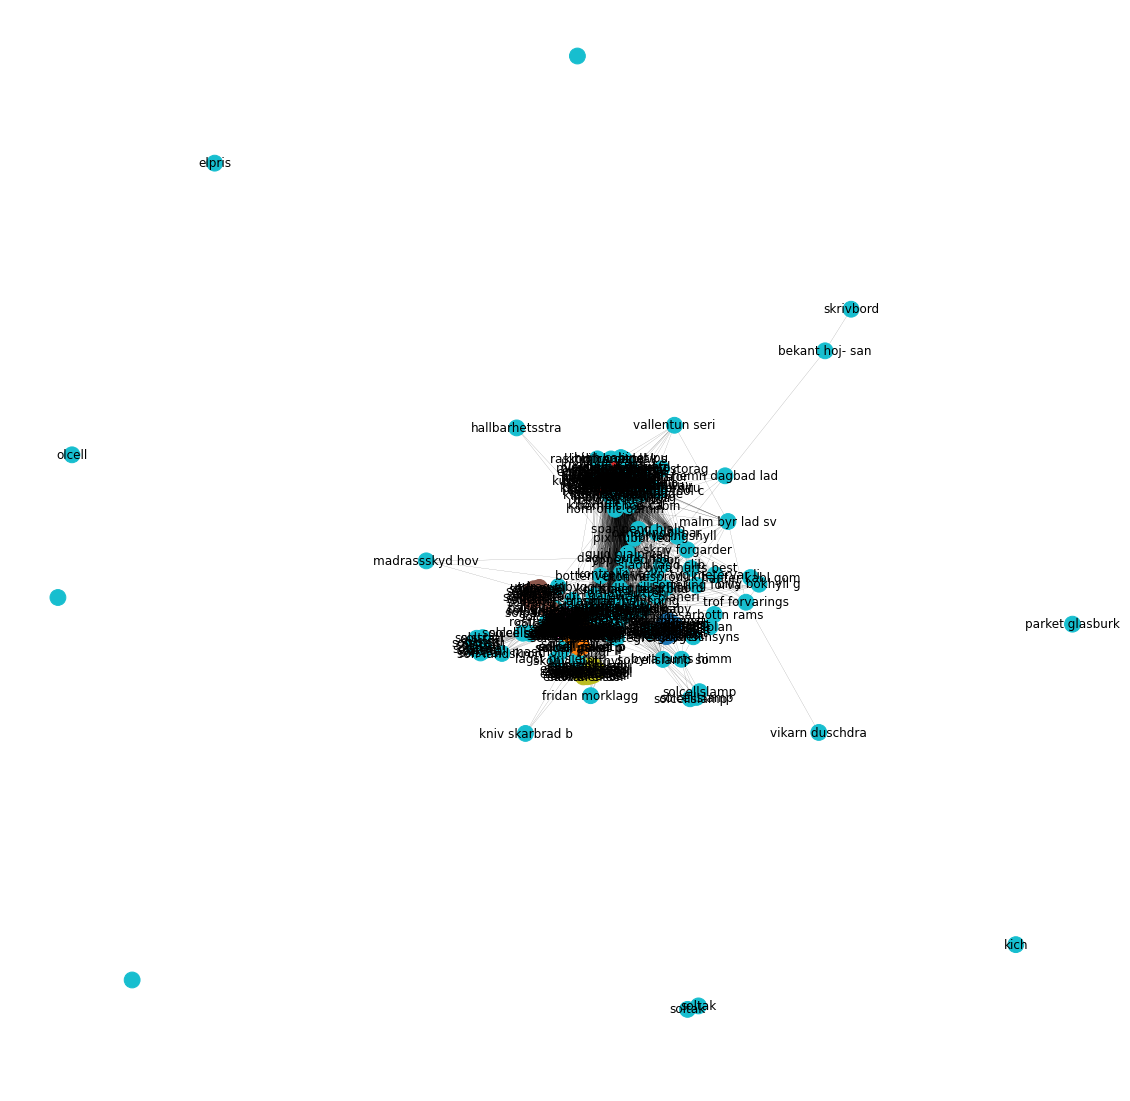

In [59]:
# Draw clusters
G = nx.from_pandas_adjacency(pd.DataFrame(X_cv_cs))

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, 
        pos=nx.spring_layout(G),
        node_size=250, 
        width = 0.1,
        node_color = kmeans.labels_,
        cmap=plt.get_cmap('tab10'),
        labels=df.doc.apply(lambda x: x[:15]), 
        with_labels=True, 
        ax=ax
       )

In [60]:
from sklearn.cluster import DBSCAN

cl_dbs = DBSCAN(
    eps=.25, 
    min_samples=2
).fit(X_cv_cs)
cl_dbs.labels_

array([-1, -1, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0,  0, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  0, -1, -1, -1,  0, -1,  0, -1, -1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

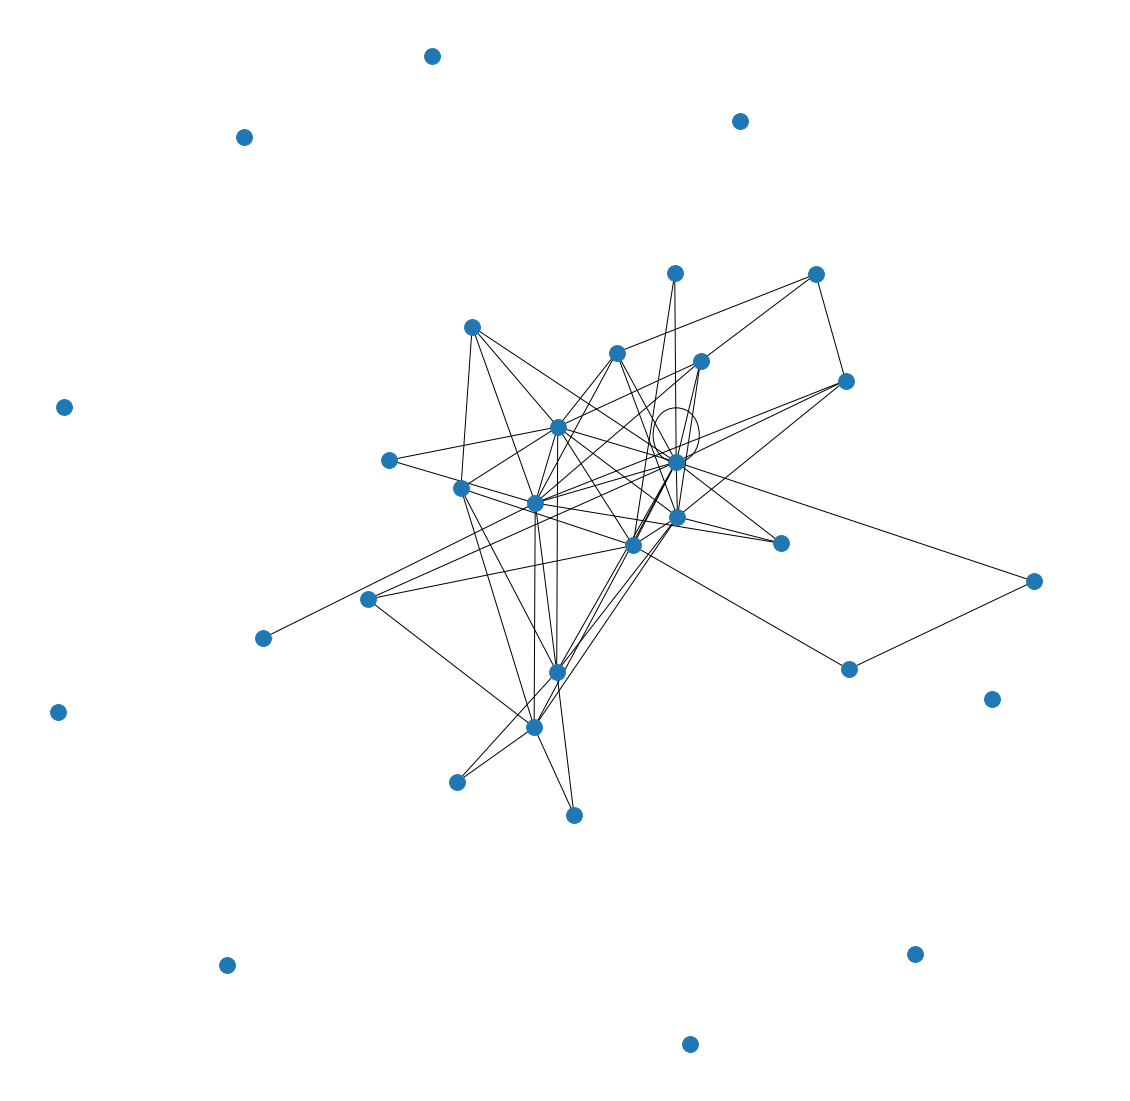

In [61]:
top_words_dict = {}
for i in range(0, len(set(cl_dbs.labels_))-1):
    tokens = nltk.tokenize.word_tokenize(" ".join(df.loc[(cl_dbs.labels_ == i), 'doc']))
    fdist = FreqDist(ngrams(tokens, 1))
    words_count = {k[0]:v for k,v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)[:10:]}
    top_words_str = " ".join([k for k in words_count][:5])
    top_words_dict[i] = top_words_str
top_words_dict


# Draw clusters
G = nx.from_pandas_adjacency(pd.DataFrame(
    X_cv_cs[cl_dbs.labels_ == 0]
))

fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, 
        pos=nx.spring_layout(G),
        node_size=250, 
#         node_color = cl_dbs.labels_,
        cmap=plt.get_cmap('tab10'),
#         labels=df.doc.apply(lambda x: x[:15]), 
#         with_labels=True, 
        ax=ax
       )

In [62]:
import hdbscan

# https://hdbscan.readthedocs.io/en/0.8.4/api.html

cl_hdbs = hdbscan.HDBSCAN(
    min_samples = 5, 
    min_cluster_size = 5,
    gen_min_span_tree = False,
)
cl_hdbs.fit(X_cv_cs)
cl_hdbs.labels_

array([-1, -1, -1, -1, -1, -1,  7,  7,  7,  7, -1, -1, -1,  7, -1, -1, -1,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1,  4,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  7,  7,  7,  7,  7, -1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1, -1, -1,  3,  3,
        3,  7, -1, -1,  7,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3, -1, -1, -1, -1,  7,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,
       -1, -1, -1,  8,  7,  7, -1, -1, -1, -1,  7,  7,  7, -1,  7, -1, -1,
        6,  6,  6,  6,  6,  6,  6,  6,  6, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  7,  7,  7, -1, -1,  7,  7,  7,  7, -1,  7,  7, -1,
        8, -1, -1,  7, -1, -1, -1, -1,  8,  7,  8,  7,  7,  7, -1, -1, -1,
        7, -1, -1, -1, -1, -1, -1, -1,  7,  7, -1,  7, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
        8, -1, -1, -1,  8

In [63]:
bow_mat[cl_hdbs.labels_ == 7]['doc']

6                                                       
7                                                       
8         billy bokhyll glasdorr gra metallikeffek billy
9                                                       
13     pixl fubbl led vagglamp mobl inredning inspira...
44                                       parket glasburk
45                                                olcell
46                                                elpris
47                                              hyllplan
48                                                  kich
69                                        vallentun seri
72     rostfrit rostfrit stal flask flaskborst krosam...
73                                             skrivbord
95     byra hurts best forvaring dorr svartbrun bjork...
107                                    lagst pris erbjud
118    hemn shoe cabinet compartment dark gray gray s...
123    gallery hallway ide mossland pictur ledg ivar ...
124                            

In [64]:
top_words_dict = {}
for i in range(0, len(set(cl_hdbs.labels_))-1):
    tokens = nltk.tokenize.word_tokenize(" ".join(df.loc[(cl_hdbs.labels_ == i), 'doc']))
    fdist = FreqDist(ngrams(tokens, 1))
    words_count = {k[0]:v for k,v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)[:10:]}
    top_words_str = " ".join([k for k in words_count][:5])
    top_words_dict[i] = top_words_str
top_words_dict

{0: 'elavtal el sol vind',
 1: 'energitjanst',
 2: 'solpanel',
 3: 'solcell',
 4: 'solcell paket pris vill tak',
 5: 'solstral solcell plus',
 6: 'gallery kitch inspiration',
 7: '`` ide inspiration sof /x/',
 8: 'kitch furnitur cabinet bed desk'}

/opt/homebrew/lib/python3.9/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<AxesSubplot:ylabel='$\\lambda$ value'>

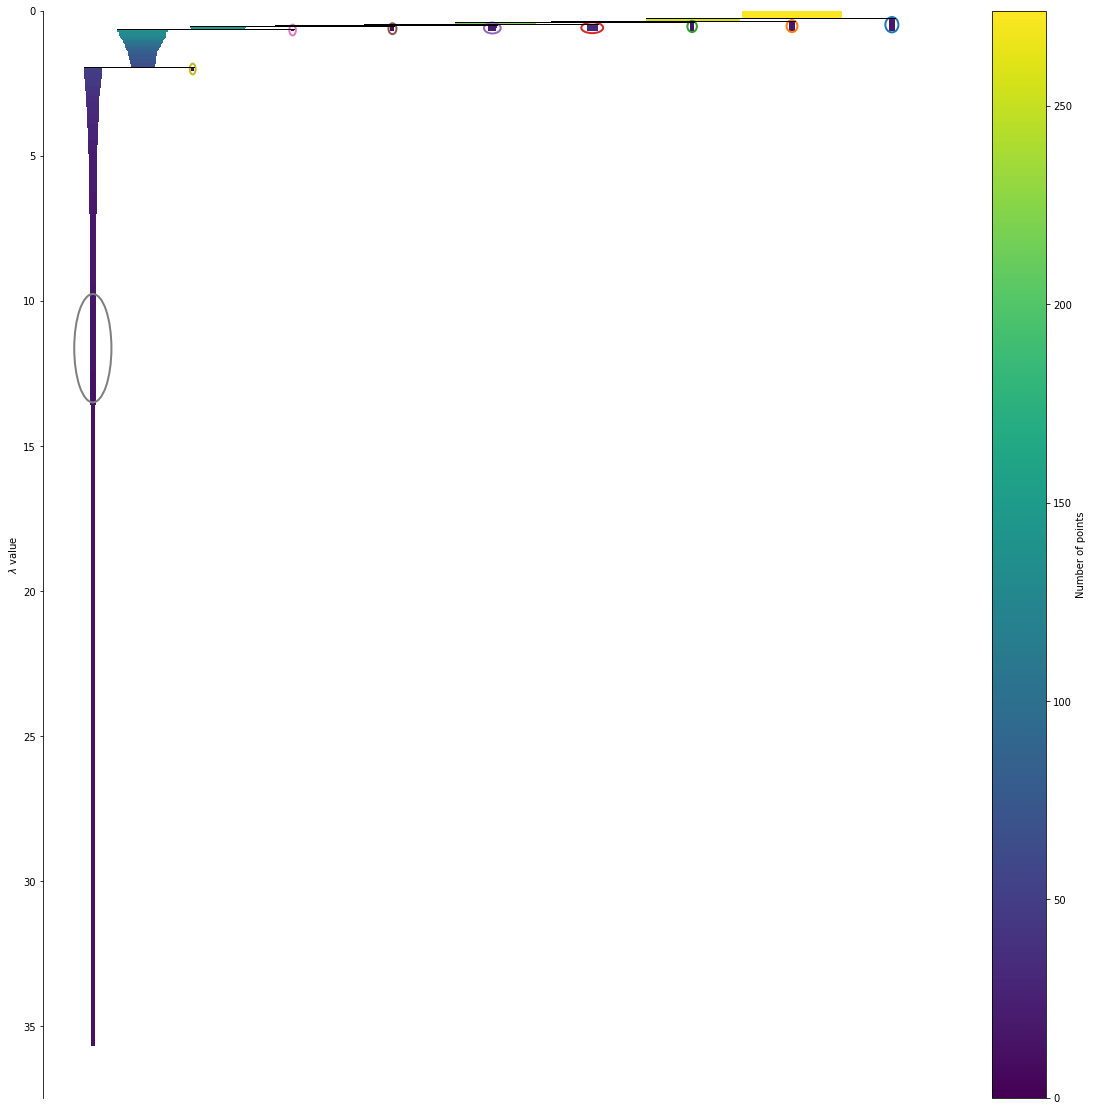

In [65]:
fig, ax = plt.subplots(figsize=(20,20))
cl_hdbs.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


1. Break page titles into keywords (or n-grams?)
2. Count keywords co-occurences on session level, put pairs into matrices.
3. Calculate cos-similarity between pairs.
4. Cluster (kmeans, dbscan, hdbscan)
